In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import yaml
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import curve_fit

from src.analysis import (get_forecasts, calc_fitting_params)
from src.algorithms.lstm import train_and_test_lstm
from src.load_saved_data import (
    load_load_data,
    load_generation_data,
)


In [2]:
from entsoe import EntsoePandasClient
from dotenv import load_dotenv

from src.entsoe_data_imports import (
    get_generation,
    get_wind_solar_forecast,
    get_load_and_forecast,
    get_capacities,
    get_wind_solar_intraday_forecast
)


load_dotenv('api_key.venv')
api_key = os.getenv('ENTSOE_API_KEY')
years = [2021, 2022, 2023, 2024]
# zones = ['NO_2', 'NO_3', 'NO_4', 'DK_1']
zones = ['NO_1']
load_zones = ['NO_1', 'NO_2', 'NO_3', 'NO_4', 'NO_5', 'DK_1']
download_data = True
carriers = [
    'Wind Onshore', 
    # 'Solar'
    ]

if download_data:
    client = EntsoePandasClient(api_key=api_key)
    
    get_generation(client, zones, years)  # Get generation data for all carriers for the specified zones and years
    get_wind_solar_forecast(client, zones, years, carriers=carriers)

    # get_wind_solar_intraday_forecast(client, zones, years, carrier='Wind Onshore')

    # get_load_and_forecast(client, load_zones, years)
    for carrier in carriers:
        get_capacities(client, zones, years, carrier=carrier)

    


In [ ]:
error_type = "wind"
zone = 'NO_2'
years = [2022, 2023, 2024]

In [5]:
years = [2021, 2022, 2023, 2024]
years = [2022, 2023, 2024]
# zones = ['NO_2', 'NO_3', 'NO_4', 'DK_1']
zones = ['ES']
error_type = "Wind Onshore"
imbalance = {}

for zone in zones:
    if error_type == "load":
        target_series, forecast_series, scaling_value = load_load_data(years, zone, detrend_flag=False)
    else:
        target_series, forecast_series, scaling_value = load_generation_data(years, zone, carrier=error_type, detrend_flag=False)

    imbalance[zone] = (target_series - forecast_series).abs().mean()
print(imbalance)

{'ES': np.float64(738.4777882146906)}


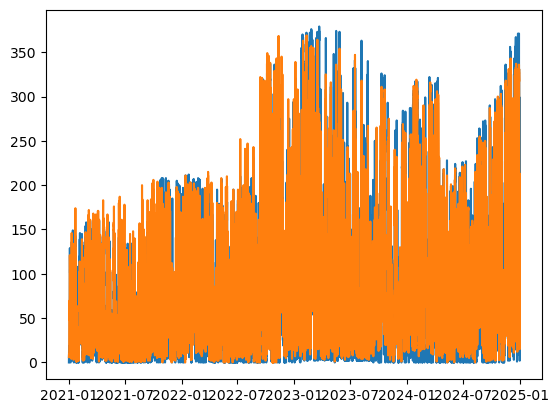

In [4]:
plt.plot(target_series.index, target_series, label='Target Series')
plt.plot(forecast_series.index, forecast_series, label='Forecast Series')

In [1]:
from src.load_config import ConfigSettings

config = ConfigSettings('spain.yaml')
config
config.error_types = ['load']

In [2]:

from src.forecasting import get_forecast_loop

get_forecast_loop(config)
    
    


Processing error type load...
Training LSTM model for n_lead_time = 1
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training LSTM model for n_lead_time = 2
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Training LSTM model for n_lead_time = 3
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training LSTM model for n_lead_time = 4
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training LSTM model for n_lead_time = 5
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training LSTM model for n_lead_time = 6
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Training LSTM model for n_lead_time = 7
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training LSTM model for n_lead_time = 8
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [2]:
from src.fitting import calc_fitting_params_loop



param_df, rmse_dict = calc_fitting_params_loop(config=config)
    


ValueError: Input contains NaN.

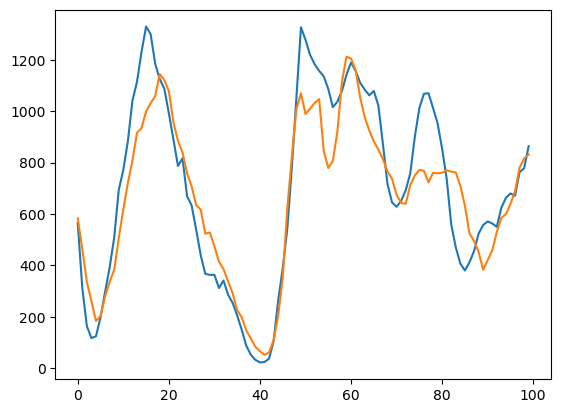

In [ ]:
itmin, itmax = 0, 100
lt = 4
from src.forecast_data_handling import get_data
y_test_dict, y_pred_dict, scaling_value, target_series, forecast_series = get_data("data/")
plt.plot(y_test_dict['NO_3'][lt][itmin:itmax], label='Target Series')
plt.plot(y_pred_dict['NO_3'][lt][itmin:itmax], label='Predicted Series')



In [ ]:
from src.analysis import (
    get_forecasts, 
    calc_fitting_params,
)


def asymptotic_func(x, a, b):
    return a * x / (x + b)

years = [2023, 2024]
error_type = "Wind Onshore"
zone = 'ES'
if error_type == "load":
    target_series, forecast_series, scaling_value = load_load_data(years, zone, folder="data")
else:
    target_series, forecast_series, scaling_value = load_generation_data(years, zone, carrier=error_type)

    

zones = ['ES']
max_lead_time = 12
n_lags = 7
lead_time_range = range(1, max_lead_time + 1)
for error_type in ["wind"]:
    y_test_dict, y_pred_dict, scaling_value_dict = get_forecasts(
        error_type, 
        years,
        zones,
        train_and_test_function=train_and_test_lstm,
        n_lags=n_lags, 
        lead_time_range=lead_time_range
    )

    param_df, rmse_dict = calc_fitting_params(
        lead_time_range,
        zones, 
        y_test_dict,
        y_pred_dict,
        scaling_value_dict,
        fitting_function=asymptotic_func,
    )


    param_df.to_csv(f"data/processed/{error_type}_fitting_params_lead_time_{max_lead_time}_{zone}.csv")




In [ ]:


from src.load_saved_data import (
    load_load_data,
    load_wind_data,
)
from src.algorithms.lstm import train_and_test_lstm


max_lead_time_dict = {
    "wind": 12,
    "load": 12
}
years = [2023, 2024]

n_lags = 3
rmse_per_step = []

zone = 'ES'  # Example zone
rmse_dict = {}
# for error_type in ["wind", "load"]:
for error_type in ["wind"]:
    if error_type == "wind":
        target_series, forecast_series, scaling_value = load_wind_data(years, zone, folder="data")
    else:
        target_series, forecast_series, scaling_value = load_load_data(years, zone, folder="data")

    rmse_per_step = []
    max_lead_time = max_lead_time_dict[error_type]
    for n_lead_time in range(1, max_lead_time + 1):                 
        # y_test, y_pred = train_and_test_random_forest(target_series, forecast_series, n_lags=n_lags, n_lead_time=n_lead_time)
        y_test, y_pred = train_and_test_lstm(target_series, forecast_series, target_series - forecast_series, target_series.index.hour * 60 + target_series.index.minute, n_lags=n_lags, n_lead_time=n_lead_time)
        
        rmse = root_mean_squared_error(y_test, y_pred) / scaling_value
        rmse_per_step.append(rmse)


    rmse_dict[error_type] = rmse_per_step
# Assume rmse_per_step is already defined



In [7]:
years = [2024]
# zones = ['NO_2', 'NO_3', 'NO_4', 'DK_1']
zones = ['ES']

rmse_dict = {}
target_series_dict = {}
forecast_series_dict = {}

for error_type in ["Solar", "Wind Onshore"]:


    for zone in zones:
        if error_type == "load":
            target_series, forecast_series, scaling_value = load_load_data(years, zone, detrend_flag=False)
        else:
            target_series, forecast_series, scaling_value = load_generation_data(years, zone, carrier=error_type, detrend_flag=False)


        target_series_dict[error_type] = target_series
        forecast_series_dict[error_type] = forecast_series

Text(0.5, 1.0, 'RMSE Wind Onshore')

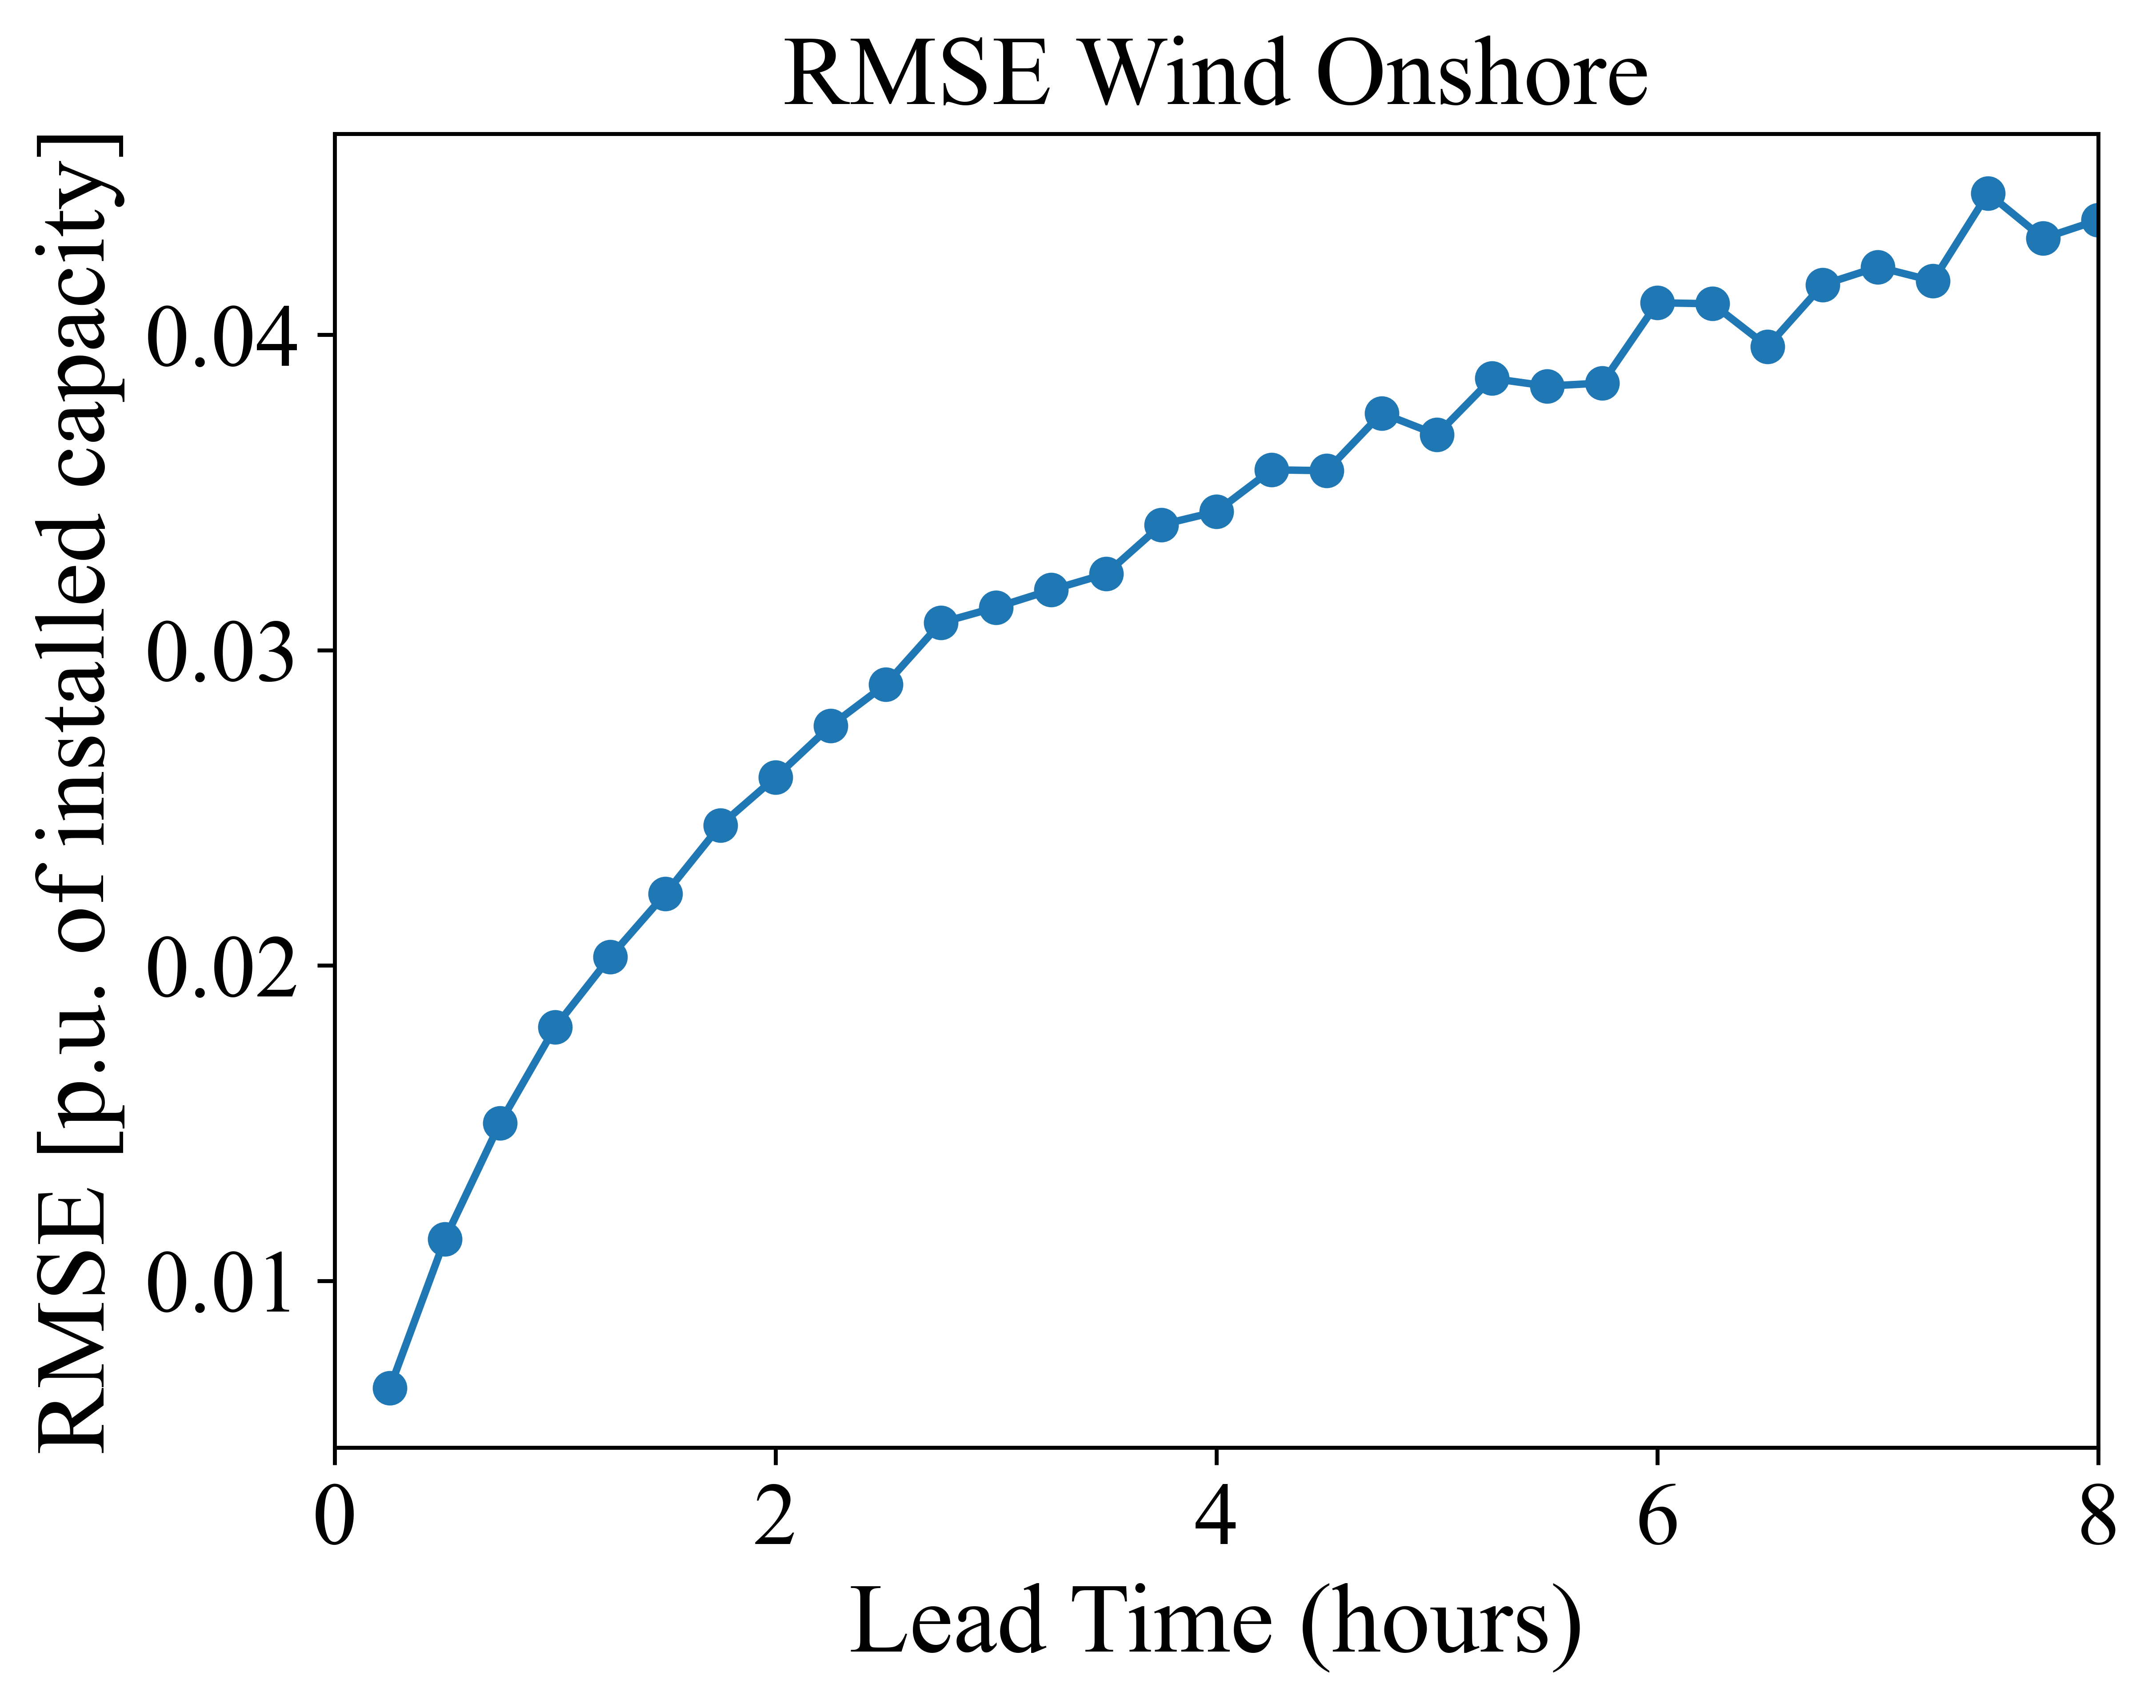

In [36]:
rmse_per_step = {}
error_type = 'Wind Onshore'
for (lead_time, y_pred), (_, y_test) in zip(y_pred_dict[error_type].items(), y_test_dict[error_type].items()):
    rmse = root_mean_squared_error(y_test, y_pred) / scaling_value
    rmse_per_step[lead_time] = rmse

rmse_ser = pd.Series(rmse_per_step)
plt.plot(rmse_ser.index/4, rmse_ser.values, marker='o')
plt.xlabel('Lead Time (hours)')
plt.ylabel('RMSE [p.u. of installed capacity]')
plt.xlim((0, 8))
plt.title('RMSE Wind Onshore')
# plt.savefig(f'figures/processed/rmse_per_step_solar.png', dpi=300)

In [ ]:
import matplotlib.cm as cm
import numpy as np
from src.forecast_data_handling import get_data
error_type = "Solar"




y_test = y_test_dict[error_type][5]
start_index = target_series.index.size - y_test.size
tests = target_series.iloc[start_index:]


day = 8
month = 7
year = 2024

subset = tests.loc[(tests.index.month == month) & (tests.index.day == day) & (tests.index.year == year)] 
y_test_ser = pd.Series(y_test, index=tests.index).loc[subset.index]



# Suppose you have max_lead_time
max_lead_time = 4 * 8   # Example

# Create a sequential colormap
cmap = plt.get_cmap('Reds')  # You can use others like 'plasma', 'cividis', 'Blues'
plt.plot(forecast_series.loc[subset.index], label='ENTSO-E day-ahead', linestyle='--')
plt.plot(target_series.loc[subset.index], label='Actual', color='black')
# Generate equally spaced color indices
colors = [cmap(i / max_lead_time) for i in range(1, max_lead_time + 1)]
plt.plot(y_test_ser.index, y_test_ser.values, label='Test Data', color='black')
pred_dict = {}
for n_lead_time in range(4, max_lead_time + 1, 4):

        start_index = target_series.index.size - y_pred_dict[error_type][n_lead_time].size
        tests = target_series.iloc[start_index:]

        subset = tests.loc[(tests.index.month == month) & (tests.index.day == day)  & (tests.index.year == 2024)] 

        y_pred_ser = pd.Series(y_pred_dict[error_type][n_lead_time], index=tests.index).loc[subset.index]
        pred_dict[n_lead_time] = y_pred_ser

        plt.plot(y_pred_ser.index, y_pred_ser.clip(0).values, label='Predictions', color=colors[max_lead_time-1 - (n_lead_time-1)])

plt.savefig(f'plots/example_forecasts_{day}_{month}_{year}_{error_type.replace(' ', '_')}_{zone}.pdf')

NameError: name 'target_series_dict' is not defined

In [ ]:
from src.utils import get_hourly

def get_forecast_df(target_series, forecast_series, y_pred_dict, month=7, day=8, n_steps=4):

    pred_dict = {}
    for n_lead_time in range(n_steps, config.max_lead_time + 1, n_steps):

            start_index = target_series.index.size - y_pred_dict[error_type][n_lead_time].size
            tests = target_series.iloc[start_index:]

            subset = tests.loc[(tests.index.month == month) & (tests.index.day == day)  & (tests.index.year == 2024)] 

            y_pred_ser = pd.Series(y_pred_dict[error_type][n_lead_time], index=tests.index).loc[subset.index]
            pred_dict[n_lead_time] = y_pred_ser
    pred_df = pd.DataFrame(pred_dict)
    pred_df.columns = (pred_df.columns / n_steps).astype(int)
    hourly_pred = pred_df.loc[pred_df.index.minute == 0, :]
    hourly_pred.index = hourly_pred.index.hour
    hourly_pred
    forecasts_dict = {}
    delivery_hours = pred_df.index
    actual = target_series.loc[subset.index]
    default_forecast = get_hourly(forecast_series.loc[subset.index])
    default_forecast.index = default_forecast.index.hour
    actual = get_hourly(actual)
    actual.index = actual.index.hour
    df = hourly_pred.clip(0)
    # forecast_times = [-9 , -2, 4]

    forecast_times = np.concat([np.array([-12, -9]), np.array(range(-2, 24))])
    # forecast_times = np.array(range(-1, 24))
    # forecast_times = np.array([-12, -9])
    delivery_hours = range(24)

    # Container for final forecasts
    forecasts_dict = {}

    for f_time in forecast_times:
        forecast_values = []
        for dh in delivery_hours:
            # Calculate lead time
            lt = dh - f_time

            if lt in df.columns:

                val = df.loc[dh, lt]
            elif lt <= 0:
                val = actual.loc[dh]
            else:
                val = default_forecast.loc[dh]
            forecast_values.append(val)

        forecasts_dict[f_time] = pd.Series(forecast_values, index=delivery_hours)

    # Final forecasts DataFrame
    forecasts_df = pd.DataFrame(forecasts_dict)
    return forecasts_df


from src.forecast_data_handling import get_data
y_test_dict, y_pred_dict, scaling_value, target_series, forecast_series = get_data(...)
    

forecasts_df = get_forecast_df(
    target_series,
    forecast_series,
    y_pred_dict,
    month=7,
    day=8,
    n_steps=4
)

In [29]:
from src.utils import make_dir
forecasts_df.index.name = "delivery_hour"
forecasts_df.columns.name = "forecast_time"

error_type_name = error_type.replace(' ', "_")
forecasts_df.loc[:, 'actual'] = forecasts_df.loc[:, 23]

make_dir(f"output/{zone}/{error_type_name}")
forecasts_df.to_csv(f"output/{zone}/{error_type_name}/{day}_{month}_{year}.csv")

forecasts_df


forecast_time,-12,-9,-2,-1,0,1,2,3,4,5,...,15,16,17,18,19,20,21,22,23,actual
delivery_hour,,,,,,,,,,,,,,,,,,,,,
0,562.0,562.0,880.527954,672.020203,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,...,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.0,592.0
1,564.0,564.0,725.777161,654.195435,590.005798,560.000000,560.000000,560.000000,560.000000,560.000000,...,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.0,560.0
2,549.0,549.0,672.825134,433.105774,636.555298,551.431580,560.000000,560.000000,560.000000,560.000000,...,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.0,560.0
3,559.0,559.0,628.988770,552.120300,446.833313,571.445923,559.597107,560.000000,560.000000,560.000000,...,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.0,560.0
4,408.0,408.0,543.486816,459.596222,449.432343,376.976868,517.681763,477.036591,524.000000,524.000000,...,524.000000,524.000000,524.000000,524.000000,524.000000,524.000000,524.000000,524.000000,524.0,524.0
5,973.0,973.0,602.144409,655.223877,656.677002,691.777039,639.078430,657.500122,750.230652,384.000000,...,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.0,384.0
6,4867.0,4867.0,3674.892334,3454.300781,3235.172363,3365.201904,3565.445557,3306.959717,3637.662842,3181.336914,...,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.0,2704.0
7,11310.0,11310.0,11310.000000,10218.602539,10200.484375,10061.773438,10290.561523,10383.035156,9959.705078,9769.574219,...,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.0,9552.0
8,15669.0,15669.0,15669.000000,15669.000000,14994.760742,15315.262695,14836.868164,14849.993164,15066.775391,14840.440430,...,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.0,14700.0


(0.0, 23.0)

<Figure size 9600x4800 with 0 Axes>

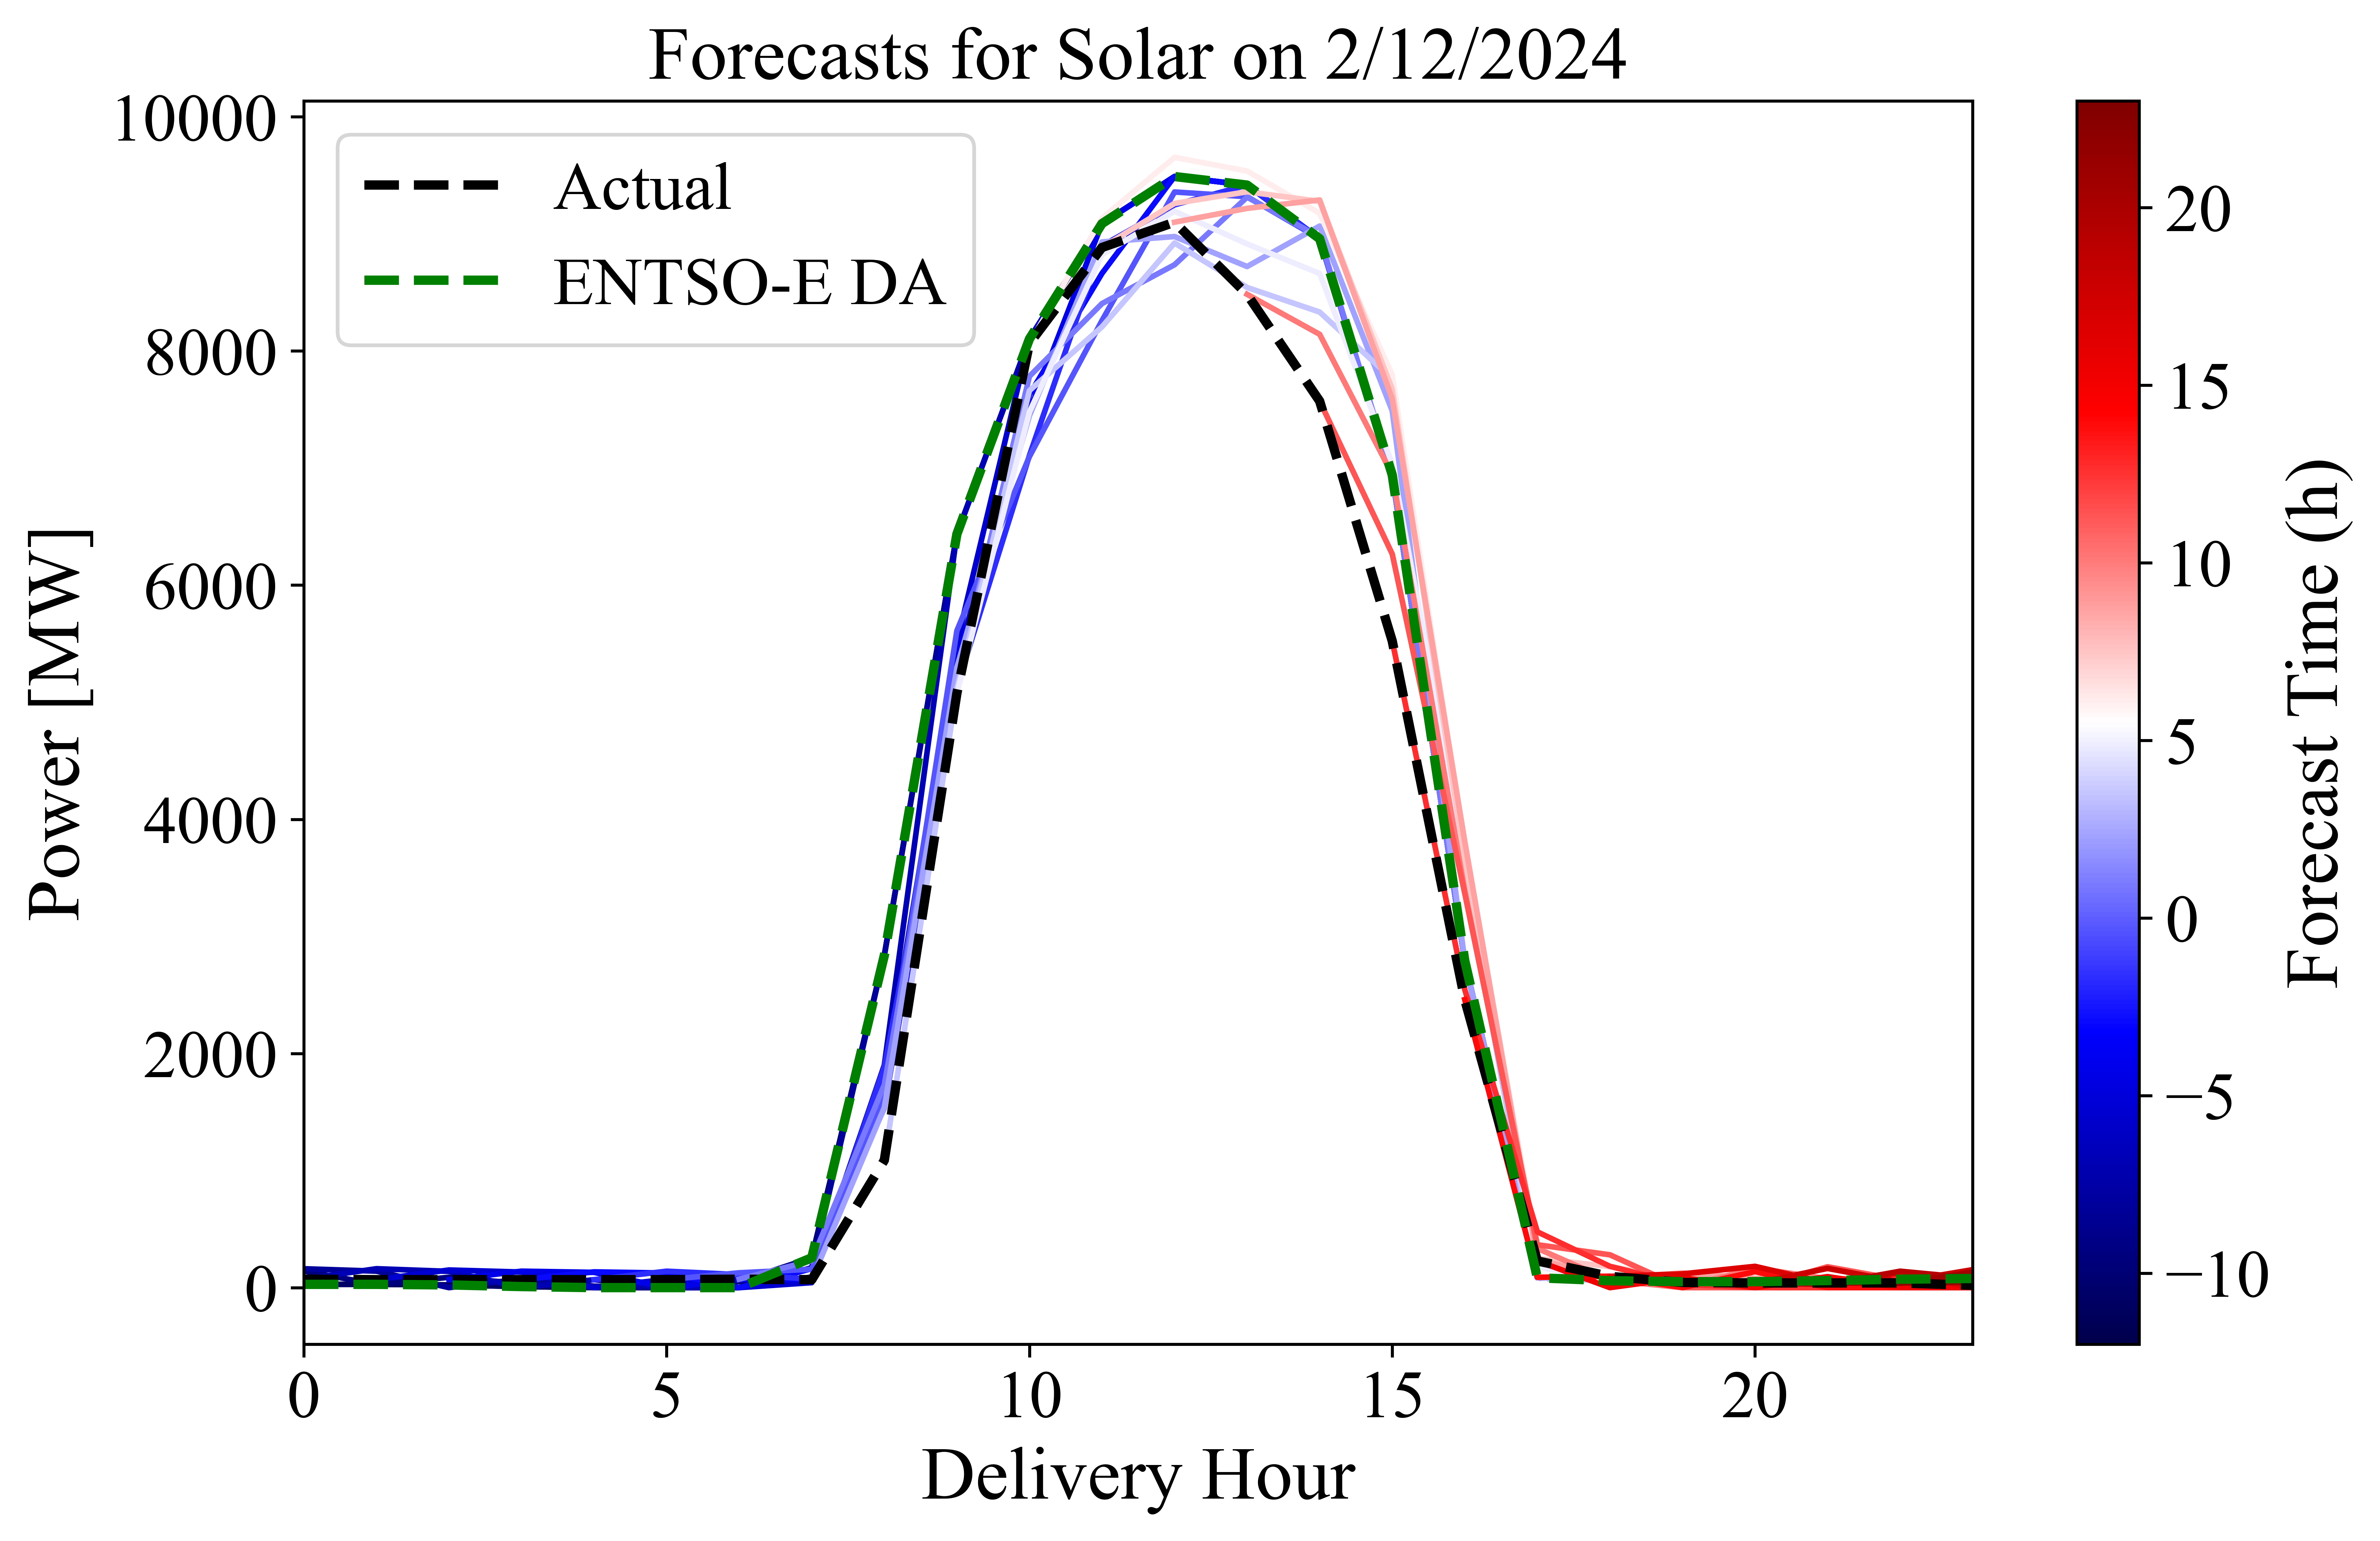

In [16]:
from src.plotting.plotting_config import set_plt_settings

set_plt_settings()

forecasts = forecasts_df.loc[:, forecasts_df.columns != 'actual']

plt.figure(figsize=(12, 6))

cmap = plt.get_cmap('seismic')  # You can use others like 'plasma', 'cividis', 'Blues'

colors = cmap(np.linspace(0, 1, len(forecasts.columns)))
fig, ax = plt.subplots(figsize=(10, 6))
for i, (col, color) in enumerate(zip(forecasts.columns, colors)):
    # if i is divisible by 4:
        ser = forecasts[col].loc[forecasts[col].index >= float(col)]
        if ser.empty:
            continue
        ax.plot(ser.index, ser,  color=color)

ax.plot(actual, color='k', linewidth=2.5, label='Actual', linestyle='--')
ax.plot(default_forecast, label='ENTSO-E DA', linestyle='--', color='green', linewidth=2.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(forecasts.columns), vmax=max(forecasts.columns)))
sm.set_array([])  # Required for matplotlib 3.x
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Forecast Time (h)')
plt.ylabel("Power [MW]")
plt.xlabel("Delivery Hour")
plt.title(f"Forecasts for {error_type} on {day}/{month}/{year}")
plt.xlim((0, 23))
# plot colorbar for the forecasts


In [ ]:
forecasts_df[col].loc[forecasts_df[col].index <= col] = pd.NA
forecasts_df[col]

In [ ]:
target_series = target_series_dict["Wind Onshore"]
forecast_series = forecast_series_dict["Wind Onshore"]

plt.plot(target_series)
plt.plot(forecast_series)

In [ ]:
folder = "data/input_entsoe"
carrier = "Solar"
from src.load_saved_data import set_datetime_index

wind_series = pd.concat([
        pd.read_csv(f'{folder}/generation/{zone}/{year}.csv', index_col=0, parse_dates=True, dtype=float)[carrier] 
        for year in years], axis=0)
    
wind_forecast_series =  pd.concat([
    pd.read_csv(f'{folder}/generation_forecasts/{carrier}/{zone}/{year}.csv', index_col=0, parse_dates=True, dtype=float)[carrier] 
    for year in years], axis=0)

wind_series = set_datetime_index(wind_series)
wind_forecast_series = set_datetime_index(wind_forecast_series)

# drop values that are not in both series
wind_series = wind_series[wind_series.index.isin(wind_forecast_series.index)]
wind_forecast_series = wind_forecast_series[wind_forecast_series.index.isin(wind_series.index)]

capacity = pd.read_csv(f'{folder}/mean_capacities/{carrier.replace(' ', '_')}/{zone}.csv', index_col=0).loc[zone].values[0]


In [ ]:
test_set = wind_forecast_series.iloc[start_index:]
test_set.loc[(test_set.index.month == 12)].plot()

In [14]:
rmse_series = {error_type: pd.Series(rmse_dicts[error_type]['NO_3']) for error_type in rmse_dicts.keys()}

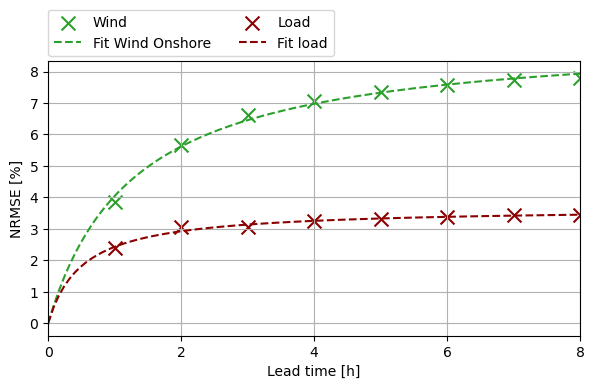

In [21]:
def asymptotic_func(x, a, b):
    return a * x / (x + b)

plt.figure(figsize=(6, 4))

error_colors = {
    "Wind Onshore": "tab:green",  
    "load": "darkred",  
}

max_lead_time_dict = {
    "Wind Onshore": 8,
    "load": 8
}

for error_type, rmse_per_step in rmse_series.items():
    horizons = np.arange(1, len(rmse_per_step) + 1)
    error_type_nice_name = "Wind" if error_type == "Wind Onshore" else "Load"
    horizons = np.arange(1, max_lead_time_dict[error_type] + 1)
    # Ensure rmse_per_step is a numpy array
    rmse_per_step = np.array(rmse_per_step)
    plotting_linspace = np.linspace(0, 8, 100)
    # Fit the function to the data

    asymptotic_params, _ = curve_fit(asymptotic_func, horizons, rmse_per_step)
    asymptotic_fitted_rmse = asymptotic_func(plotting_linspace, *asymptotic_params)

    plt.scatter(horizons, 100 * rmse_per_step, color=error_colors[error_type], marker='x', label=f'{error_type_nice_name}', s=100)
    plt.plot(plotting_linspace, 100 * asymptotic_fitted_rmse, linestyle='--', color=error_colors[error_type], label=rf'Fit {error_type}')

plt.xlabel("Lead time [h]")
plt.xticks([0, 2, 4, 6, 8])

plt.ylabel("NRMSE [%]")
plt.grid(True)
plt.legend(bbox_to_anchor=(0., 1.02), loc='lower left', borderaxespad=0., ncols=2)
plt.tight_layout()
plt.xlim((0, 8))
plt.savefig(f'plots/nrmse_NO3_top_legend.pdf', bbox_inches='tight')
plt.show()

In [24]:
rmse_series['Wind Onshore']

1    0.038635
2    0.056535
3    0.066292
4    0.070796
5    0.073640
6    0.075625
7    0.077336
8    0.078021
dtype: float64

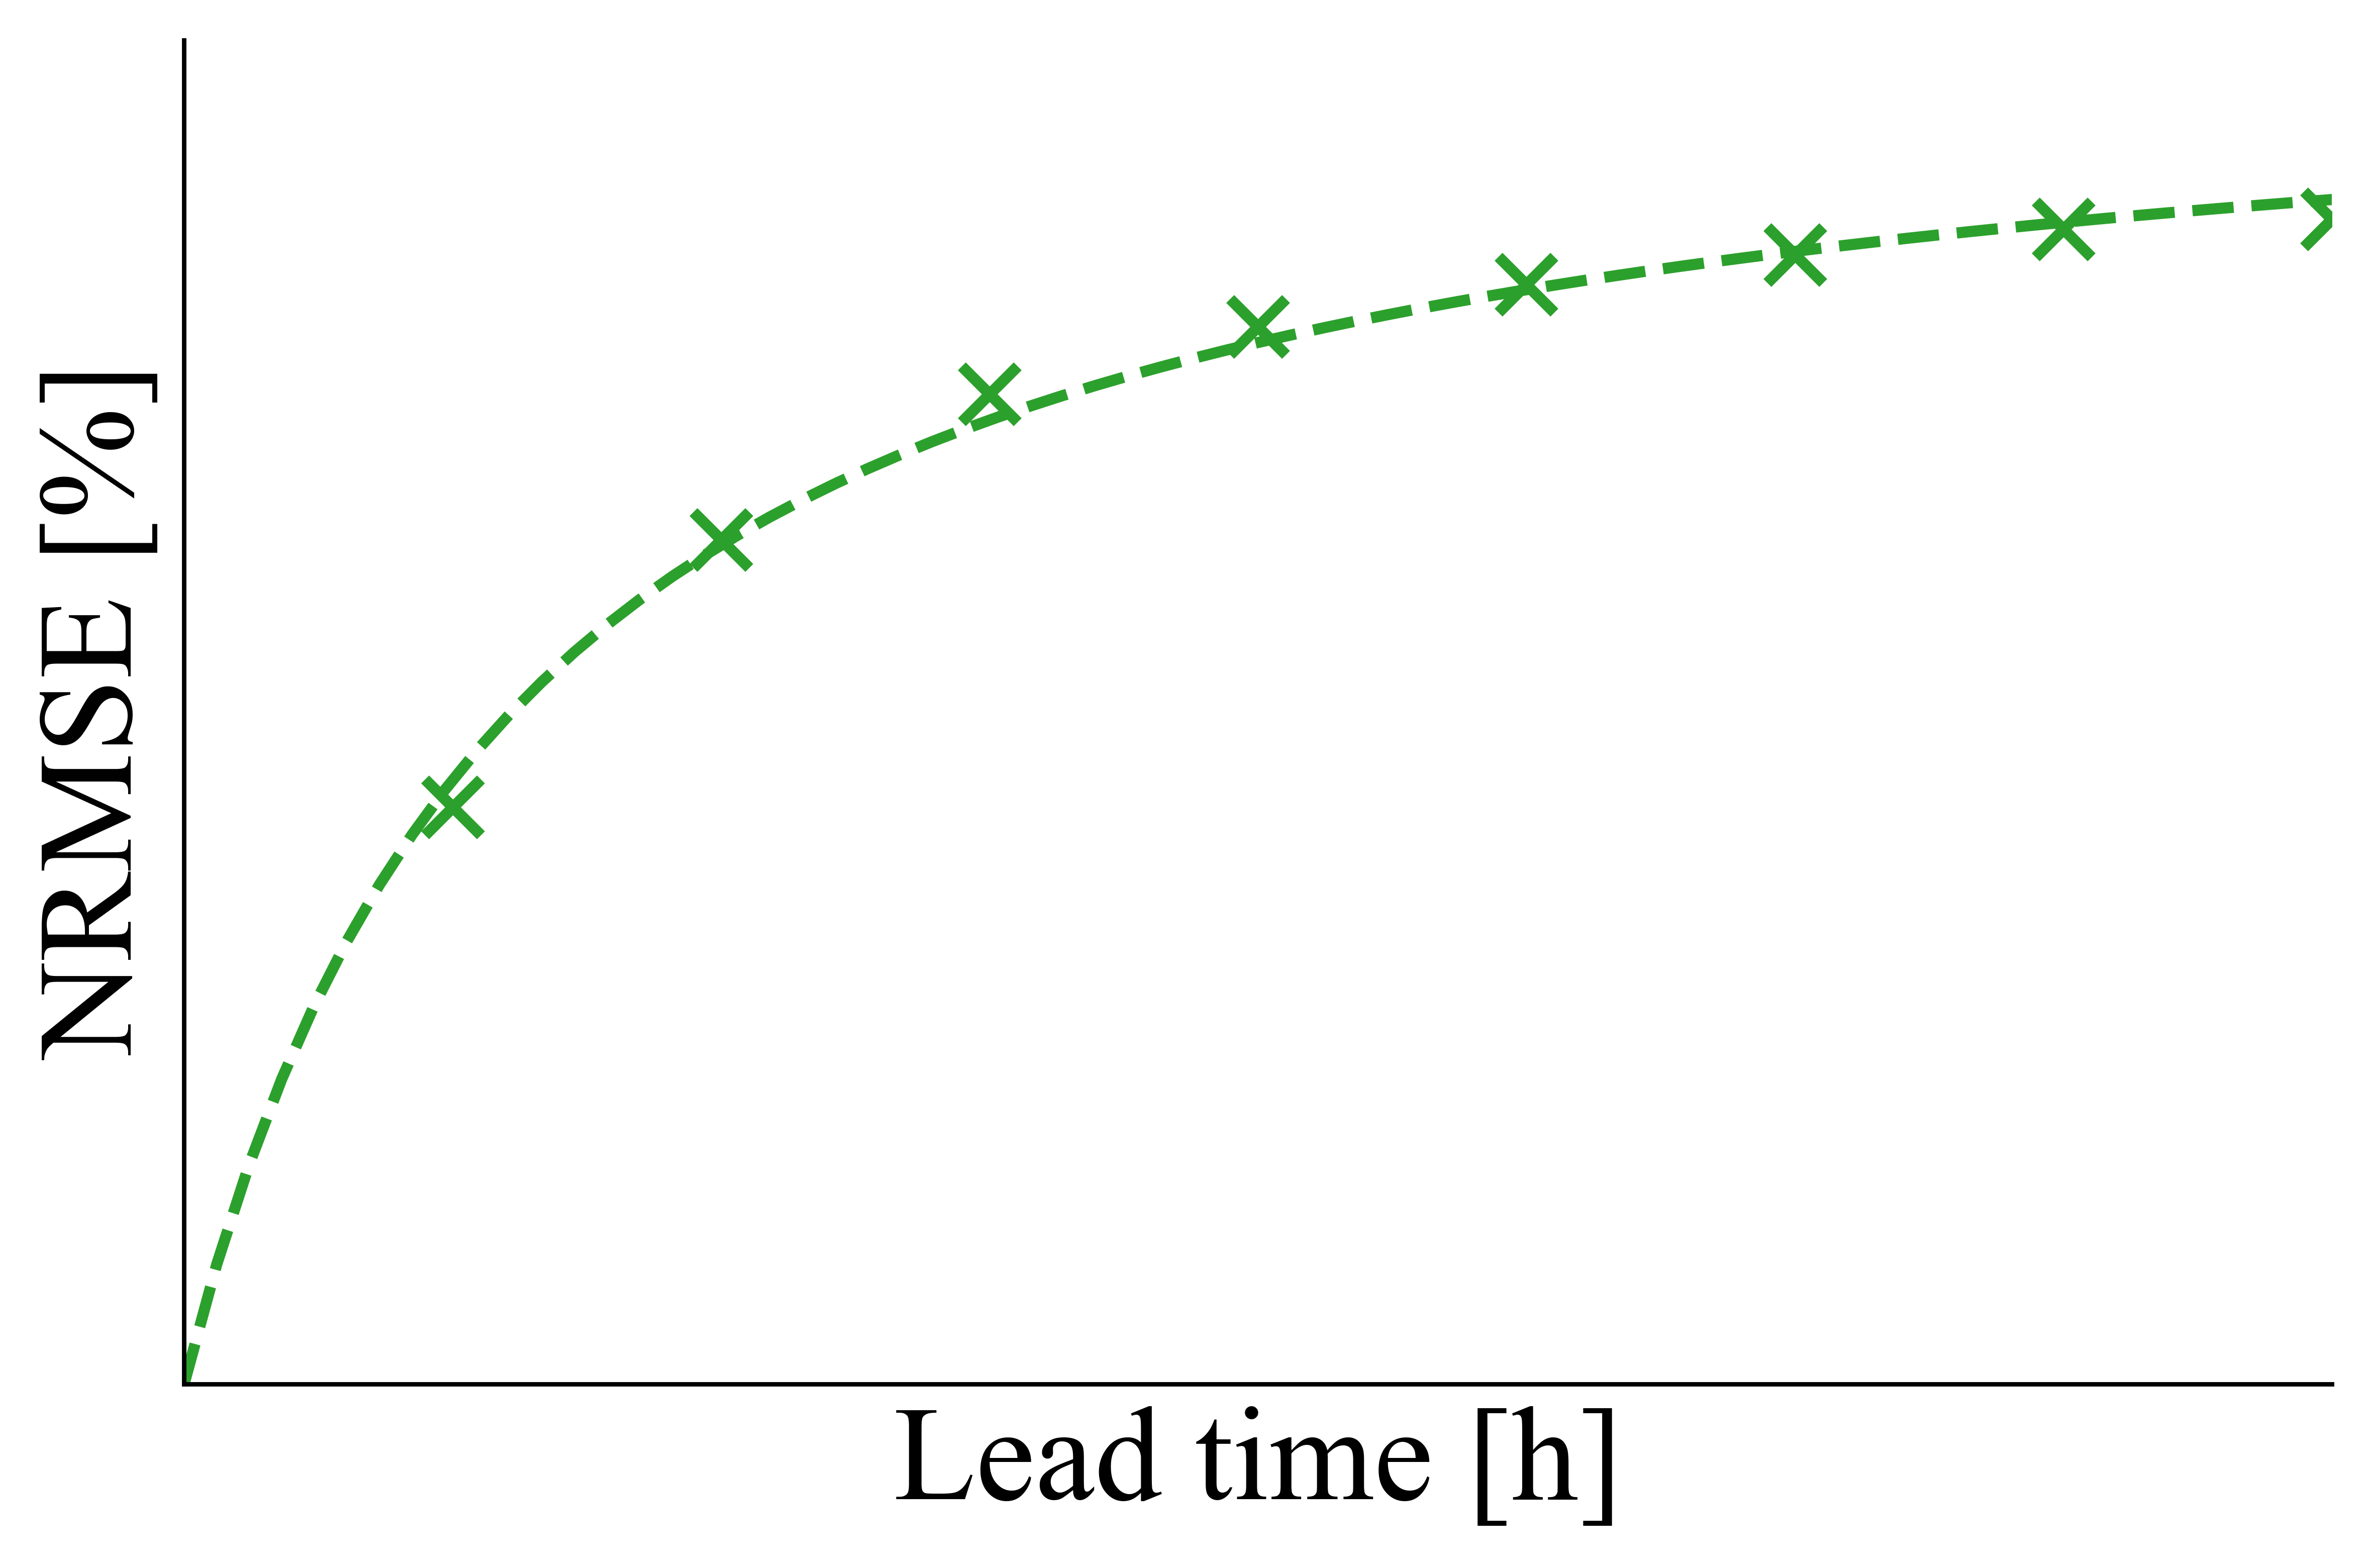

In [27]:
from src.plotting.plotting_config import set_plt_settings

def asymptotic_func(x, a, b):
    return a * x / (x + b)

set_plt_settings()

# rmse_per_step = pd.read_csv("data/processed/rmse_per_step_example.csv", index_col=0)
rmse_per_step = rmse_series['Wind Onshore']
label_size = 24

fig, ax = plt.subplots(figsize=(6, 4))

error_colors = {
    "Wind Onshore": "tab:green",  
    "load": "darkred",  
}
max_lead_time_dict = {
    "Wind Onshore": 8,
}
error_type = "Wind Onshore"
# rmse_per_step = rmse_dict["wind"]
horizons = np.arange(1, len(rmse_per_step) + 1)
error_type_nice_name = "Wind" if error_type == "wind" else "Load"
horizons = np.arange(1, max_lead_time_dict[error_type] + 1)
# Ensure rmse_per_step is a numpy array
rmse_per_step = np.array(rmse_per_step)
plotting_linspace = np.linspace(0, 12, 100)
# Fit the function to the data

asymptotic_params, _ = curve_fit(asymptotic_func, horizons, rmse_per_step)
asymptotic_fitted_rmse = asymptotic_func(plotting_linspace, *asymptotic_params)

plt.scatter(horizons, 100 * rmse_per_step, color=error_colors[error_type], marker='x', label=f'{error_type_nice_name}', s=100, linewidth=2)
plt.plot(plotting_linspace, 100 * asymptotic_fitted_rmse, linestyle='--', color=error_colors[error_type], label=rf'Fit {error_type}', linewidth=2)

plt.xlabel("Lead time [h]", fontsize=label_size)
# plt.xticks([0, 3, 6, 9, 12])

plt.ylabel("NRMSE [%]", fontsize=label_size)
plt.grid(False)
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.yticks(None, None)

# turn off right spines and top spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# plt.legend(bbox_to_anchor=(0., 1.02), loc='lower left', borderaxespad=0., ncols=2)
plt.tight_layout()
plt.xlim((0, 8))
plt.ylim((0, 9))
plt.savefig('plots/sketch_nrmse.pdf', bbox_inches='tight')
plt.show()

In [ ]:
rmse_per_step = pd.read_csv("data/processed/rmse_per_step_example.csv", index_col=0)

In [ ]:
y_pred_dict['Solar']

In [ ]:


def assign_index(
        arr, 
        target_series, 
):
    """Assuming the test series are the last part of the target series, assign time indices to the test data."""
    start_index = target_series.index.size - arr.size
    return pd.Series(arr, 
              index=target_series[start_index:].index)



In [ ]:
from src.utils import get_hourly
# from src.utils import make_dir
y_pred_ser_dict = {}
y_test_ser_dict = {}
for error_type in ['Wind Onshore']:
    y_pred_ser_dict[error_type] = {}
    y_test_ser_dict[error_type] = {}
    y_pred_type = y_pred_dict[error_type]
    y_test_type = y_test_dict[error_type]
    for n_lead_time in range(4, max_lead_time + 1, 4):
        # val_a = get_hourly(assign_index(y_pred_type[n_lead_time], target_series_dict[error_type]))
        # val_b = get_hourly(assign_index(y_test_type[n_lead_time], target_series_dict[error_type]))

        y_pred_ser_dict[error_type][n_lead_time] = get_hourly(assign_index(y_pred_type[n_lead_time], target_series_dict[error_type]))
        y_test_ser_dict[error_type][n_lead_time] = get_hourly(assign_index(y_test_type[n_lead_time], target_series_dict[error_type]))

#         val_b.to_csv(f"output/{error_type}/{n_lead_time}.csv")


In [ ]:
y_pred_type[n_lead_time].size

In [ ]:
target_series_dict[error_type].size

In [ ]:
target_series_dict_sel = {
    error_type: get_hourly(ser) 
    for (error_type, ser) in target_series_dict.items()
}

In [ ]:
forecast_series_dict_sel = {
    error_type: get_hourly(ser) 
    for (error_type, ser) in forecast_series_dict.items()
}

In [ ]:
target_series_dict[error_type].loc[target_series_dict[error_type].index.minute == 0]

In [ ]:
from collections import defaultdict
import pandas as pd

def create_forecasts_dataset(pred_dict, da_forecast_series, target_series):
    """
    Build dataset of 24-hour forecasts for a specific delivery day.
    
    y_pred_dict: dict[n_lead_time] -> pd.Series indexed by delivery time
    forecast_series: pd.Series, indexed by delivery time
    target_series: pd.Series, indexed by delivery time
    delivery_day: datetime.date (e.g., pd.Timestamp('2025-06-06').date())
    
    Returns: defaultdict of forecast_time -> pd.Series (24 hourly forecasts)
    """
    # Forecast creation times relative to the start of the delivery day
    forecast_creation_offsets = np.concat([np.array([-12, -9]), np.array(range(-1, 24))])

    delivery_times = np.arange(24)
    
    forecasts_dataset = defaultdict(pd.Series)
    
    # Retrieve available lead times in dict
    available_lead_times = set(pred_dict.keys())
    
    for creation_offset in forecast_creation_offsets:
        # Forecast creation time

        forecasted_values = []
        
        for delivery_time in delivery_times:
            lead_time = (delivery_time - creation_offset)
            
            if lead_time < 0:
                # Use actual value
                value = target_series.loc[target_series.index.hour == delivery_time]
            elif lead_time in available_lead_times:
                # Use forecasted value if exists
                value = pred_dict[lead_time].loc[pred_dict[lead_time].index.hour == delivery_time]
            else:
                # Use day-ahead forecast
                value = da_forecast_series.loc[da_forecast_series.index.hour == delivery_time]
            
            forecasted_values.append(value)
        
        # Save 24-hour forecast as a Series
        forecast_series_24h = pd.Series(forecasted_values, index=delivery_times)
        forecasts_dataset[creation_offset] = forecast_series_24h
    
    return forecasts_dataset

In [ ]:
delivery_day = pd.Timestamp('2024-12-02').date()

error_types = ["Wind Onshore"]
error_type = "Solar"

y_pred_type = y_pred_ser_dict[error_type]
y_test_type = y_test_ser_dict[error_type]

    




In [ ]:
forecast_type = forecast_series_dict['Wind Onshore']
target_type = target_series_dict[error_type]
def select_day(ser, day, month, year):
    """Selects a specific day from a series."""
    return ser.loc[(ser.index.month == month) & (ser.index.day == day) & (ser.index.year == year)]
forecast = select_day(forecast_type, day=2, month=12, year=2024)
target = select_day(target_type, day=2, month=12, year=2024)


In [ ]:


y_pred_select = {
    n_lead_time: select_day(pred, day=2, month=12, year=2024) 
    for n_lead_time, pred in y_pred_ser_dict[error_type].items()
}
dataset = create_forecasts_dataset(
    y_pred_select,
    forecast,
    target,
)

In [ ]:
plt.plot(target.index.hour, target.values, label='Target', color='black', marker='o')
plt.plot(forecast.index.hour, forecast.values, label='Day-ahead forecast', linestyle='--', color='gray')
colors = plt.cm.Reds(np.linspace(0, 1, len(dataset)))
for i, (closure_time, forecasts) in enumerate(dataset.items()):
        if closure_time in [-9, -1, 5, 10, 15]:
                plt.plot(forecasts.index, forecasts.values, label=f'Forecast created at {closure_time}h', marker='o', color=colors[i])
plt.show()

In [ ]:
pd.concat(dataset[22].to_list())